In [115]:
from functools import partial
import json
from collections import defaultdict
from operator import itemgetter
from pathlib import Path
import pandas as pd
import torch
import numpy as np
from tdigest import TDigest

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib as mpl
from importlib import reload
import src.conformal  as cp
import src.temperature as ts
import src.helpers as helpers
reload(helpers)
reload(cp)
reload(ts)
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']


In [116]:
fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)

In [117]:
# path_to_experiments = Path('../experiments/')
path_to_experiments = Path('experiments/')

In [168]:
# dataset = 'mnist'
# dataset = 'svhn'
# dataset = 'fashion'
# dataset = 'cifar10'
# dataset = 'cifar100'
# dataset = 'bloodmnist'
# dataset = 'dermamnist'
# dataset = 'pathmnist'
# dataset = 'tissuemnist'
dataset = 'fitzpatrick'

experiment_names = ['tct', 'fedavg', 'central', 'tct_iid', 'fedavg_iid']

fst, snd = map(itemgetter, range(2))

if dataset == 'fitzpatrick':
    model = 'resnet18'
    # partition = 'skin_type_partition'
    partition = 'three_label_partition'
    _val_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}_pretrained_{partition}' / 'val_df.csv')
    _test_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}_pretrained_{partition}' / 'test_df.csv')
    df = pd.concat([_val_df, _test_df]).reset_index()
    experiments = {
        'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}_pretrained_{partition}'), dataset=dataset),
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_pretrained_{partition}'), dataset=dataset),
        'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_pretrained_{partition}'), dataset=dataset),
        'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
        'fedavg_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
    }
    num_classes = 114
    clients_class_map = None
else:
    clients_class_map = helpers.get_client_map(dataset)
    num_classes = sum(map(len, clients_class_map.values()))
    model = 'small_resnet14'
    experiments = {
        'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}'), dataset=dataset),
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}'), dataset=dataset),
        'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}'), dataset=dataset),
        'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition'), dataset=dataset),
        'fedavg_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition'), dataset=dataset),
    }
    
experiments = dict(filter(snd, experiments.items()))

'NoneType' object has no attribute 'name'


In [169]:
_partition = 'three_partition_label' if partition == 'three_label_partition' else 'aggregated_fitzpatrick_scale'
partitions = sorted(val_df[_partition].unique())
local_partition_trials = defaultdict(dict) 
decen_partition_trials = defaultdict(dict) 

alphas = list(map(lambda x: np.round(x, 2), np.arange(0.1, 1, 0.05)))
num_trials = 10
              
for i in range(num_trials):
    # randomly split into calibration and evaluation sets
    trial = helpers.get_new_trial(experiments, fitzpatrick_df=df if dataset == 'fitzpatrick' else None)
    trial_experiments = trial['experiments']
    val_df = trial['val_df']
    test_df = trial['test_df']
    
    # apply aggregate temperature scaling
    ts.client_temp_scale(
        trial_experiments, clients_class_map, 
        val_df=val_df, test_df=test_df,
        use_three_partition_label=True if partition == 'three_partition_label' else False,
    )
    
    # partition into clients
    val_index_map = {
        p: (val_df[_partition] == p).values for p in partitions
    }
    test_index_map = {
        p: (test_df[_partition] == p).values for p in partitions
    }
    
    for p in partitions:
        val_index = val_index_map[p]
        test_index = test_index_map[p]

        local_results = cp.get_coverage_size_over_alphas(
            trial_experiments['tct']['temp_val_scores'][val_index],
            trial_experiments['tct']['val_targets'][val_index],
            trial_experiments['tct']['temp_test_scores'][test_index],
            trial_experiments['tct']['test_targets'][test_index],
            alphas,
            method='lac', 
            allow_empty_sets=False,
        )
        local_partition_trials[p][i] = local_results
        
        client_coverages = {}
        client_sizes = {}
        for alpha in alphas:
            q = cp.get_distributed_quantile(
                trial_experiments['tct']['temp_val_scores'], trial_experiments['tct']['val_targets'], 
                alpha, method='lac', client_index_map=val_index_map,
            )
            psets = cp.inference_lac(trial_experiments['tct']['temp_test_scores'][test_index], q, allow_empty_sets=False,)
            client_coverages[alpha] = cp.get_coverage(psets, trial_experiments['tct']['test_targets'][test_index])
            client_sizes[alpha] = cp.get_size(psets)
        decen_partition_trials[p][i] = dict(coverage=client_coverages, size=client_sizes)
        
    print(f'finished trial {i}')

finished trial 0
finished trial 1
finished trial 2
finished trial 3
finished trial 4
finished trial 5
finished trial 6
finished trial 7
finished trial 8
finished trial 9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


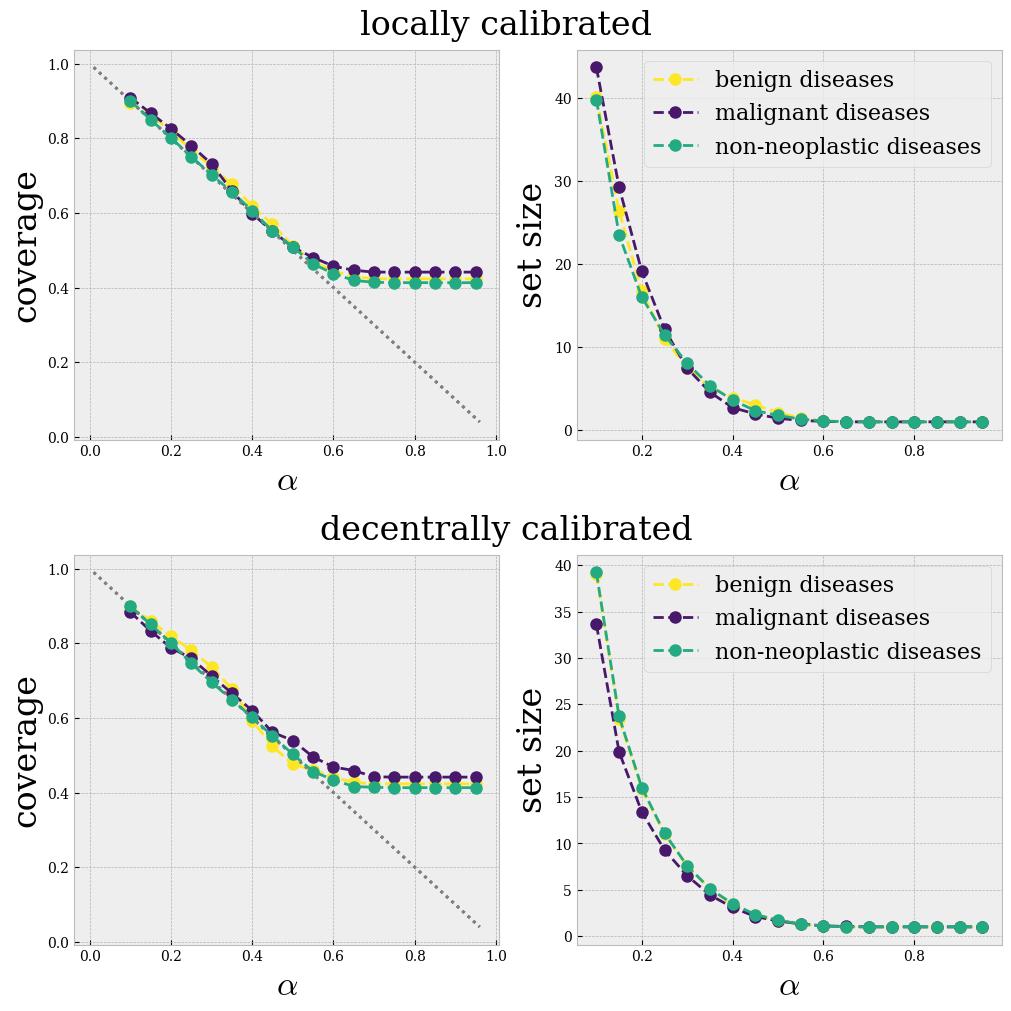

In [185]:
style = 'o--'
markersize=8
lw=2
fontsize=24
alphas=np.arange(0.01, 1, 0.05)
figsize=(12, 5)

if partition == 'aggregated_fitzpatrick_scale':
    colors = plt.cm.copper_r(np.linspace(0, 0.75, 6))
else:
    colors = [mpl.colormaps['viridis'].colors[c] for c in  [255, 16, 155]]

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
# fig.suptitle()
subfigs = fig.subfigures(nrows=2)

for col, subfig in enumerate(subfigs):

    subfig.suptitle('locally calibrated', fontsize=fontsize)
    ax = subfig.subplots(ncols=2)
    if col == 0:
        for i, (p, v) in enumerate(local_partition_trials.items()):
            local_results = helpers.combine_trials(v)['mean']
        
            ax[0].plot([min(alphas), max(alphas)], [1-min(alphas), 1-max(alphas)], ':', color='gray')

            if partition == 'aggregated_fitzpatrick_scale':
                label = f'skin type {int(p)}'
            else:
                label = f'{p} diseases'
            ax[0].plot(*zip(*local_results['coverage'].items()), style, color=colors[i], label=label, markersize=markersize, lw=lw)
            ax[1].plot(*zip(*local_results['size'].items()), style, color=colors[i], label=label, markersize=markersize, lw=lw)
            ax[0].set_xlabel(r'$\alpha$', fontsize=fontsize)
            ax[1].set_xlabel(r'$\alpha$', fontsize=fontsize)
            ax[0].set_ylabel('coverage', fontsize=fontsize)
            ax[1].set_ylabel('set size', fontsize=fontsize)
            # ax[0].legend(fancybox=True, fontsize=fontsize-8, ncol=1, loc='lower left', )#title='clients', title_fontsize=fontsize)
            ax[1].legend(fancybox=True, fontsize=fontsize-8, ncol=1, loc='upper right', )#title='clients', title_fontsize=fontsize)

    if col == 1:
        
        subfig.suptitle('decentrally calibrated', fontsize=fontsize)
        for i, (p, v) in enumerate(decen_partition_trials.items()):
            decen_results = helpers.combine_trials(v)['mean']

            ax[0].plot([min(alphas), max(alphas)], [1-min(alphas), 1-max(alphas)], ':', color='gray')

            if partition == 'aggregated_fitzpatrick_scale':
                label = f'skin type {int(p)}'
            else:
                label = f'{p} diseases'
            ax[0].plot(*zip(*decen_results['coverage'].items()), style, color=colors[i], label=label, markersize=markersize, lw=lw)
            ax[1].plot(*zip(*decen_results['size'].items()), style, color=colors[i], label=label, markersize=markersize, lw=lw)
            ax[0].set_xlabel(r'$\alpha$', fontsize=fontsize)
            ax[1].set_xlabel(r'$\alpha$', fontsize=fontsize)
            ax[0].set_ylabel('coverage', fontsize=fontsize)
            ax[1].set_ylabel('set size', fontsize=fontsize)
            # ax[0].legend(fancybox=True, fontsize=fontsize-8, ncol=1, loc='upper right', )#title='clients', title_fontsize=fontsize-4)
            ax[1].legend(fancybox=True, fontsize=fontsize-8, ncol=1, loc='upper right', )#title='clients', title_fontsize=fontsize-4)

plt.savefig(fig_dir / f'experiment-2-{dataset}-{partition}.eps', bbox_inches='tight')
plt.show()

In [ ]:
colors

KeyError: '1.0'

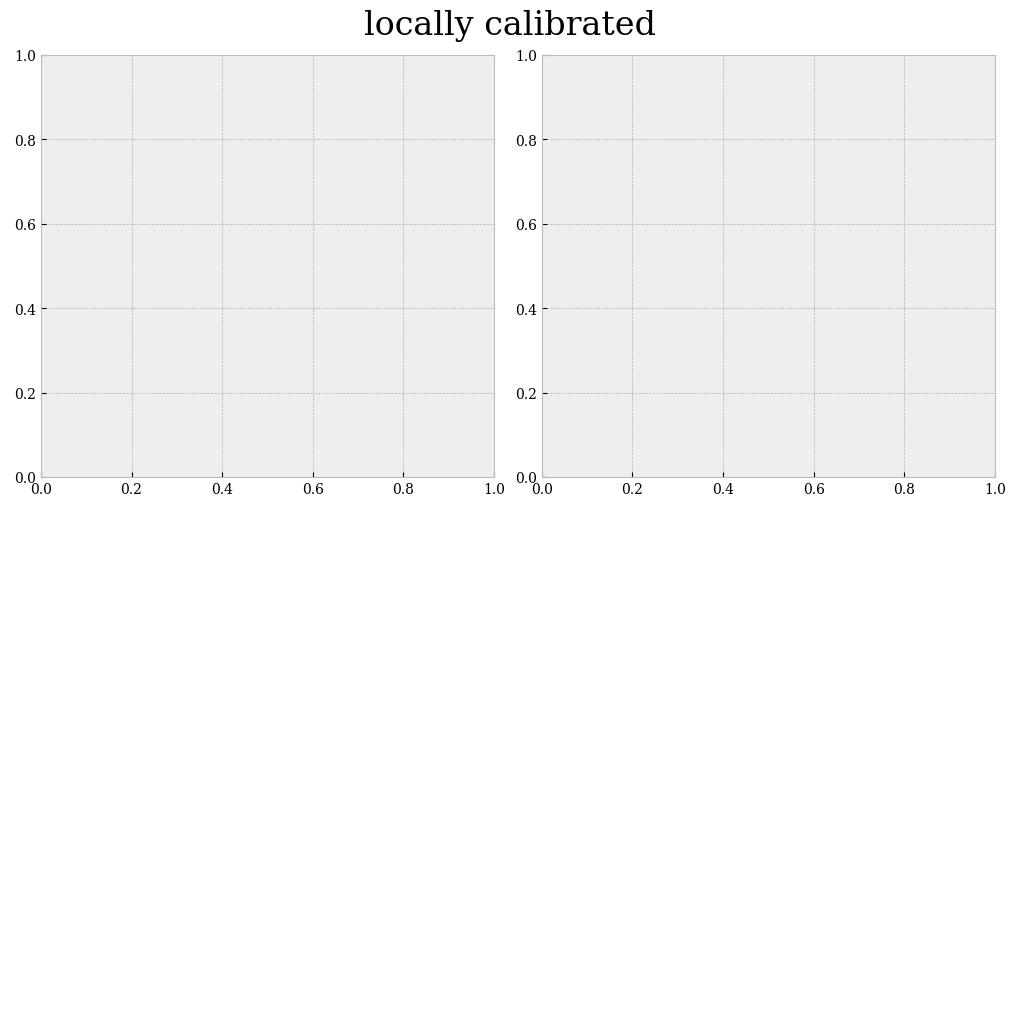

In [166]:
style = 'o--'
markersize=6
lw=2
fontsize=24
alphas=np.arange(0.01, 1, 0.05)
figsize=(12, 5)

fig = plt.figure(constrained_layout=True, figsize=(10, 10))
# fig.suptitle()
subfigs = fig.subfigures(nrows=2)

for col, subfig in enumerate(subfigs):

    subfig.suptitle('locally calibrated', fontsize=fontsize)
    ax = subfig.subplots(ncols=2)
    if col == 0:
        # fig, ax = plt.subplots(ncols=2, figsize=figsize)
        for i, st in enumerate(sorted(val_df.aggregated_fitzpatrick_scale.unique())):
            st = str(float(st))
            val_index = val_index_map[st]
            test_index = test_index_map[st]

            results = cp.get_coverage_size_over_alphas(
                experiments['tct']['temp_val_scores'][val_index],
                experiments['tct']['val_targets'][val_index],
                experiments['tct']['temp_test_scores'][test_index],
                experiments['tct']['test_targets'][test_index],
                alphas,
                method='lac', 
                allow_empty_sets=False,
            )
            ax[0].plot([min(alphas), max(alphas)], [1-min(alphas), 1-max(alphas)], ':', color='gray')

            label = f'skin type {int(float(st))}'
            ax[0].plot(*zip(*results['coverage'].items()), style, color=SKIN_COLORS[i], label=label, markersize=markersize, lw=lw)
            ax[1].plot(*zip(*results['size'].items()), style, color=SKIN_COLORS[i], label=label, markersize=markersize, lw=lw)
            ax[0].set_xlabel(r'$\alpha$', fontsize=fontsize)
            ax[1].set_xlabel(r'$\alpha$', fontsize=fontsize)
            ax[0].set_ylabel('coverage', fontsize=fontsize)
            ax[1].set_ylabel('set size', fontsize=fontsize)
            ax[0].legend(fancybox=True, fontsize=fontsize-12, ncol=1, loc='lower left', title='clients', title_fontsize=fontsize)
            ax[1].legend(fancybox=True, fontsize=fontsize-12, ncol=1, loc='upper right', title='clients', title_fontsize=fontsize)


    if col == 1:
        subfig.suptitle('decentrally calibrated', fontsize=fontsize)
        for i, st in enumerate(sorted(val_df.aggregated_fitzpatrick_scale.unique())):
            st = str(float(st))
            val_index = val_index_map[st]
            test_index = test_index_map[st]

            client_coverages = {}
            client_sizes = {}
            for alpha in alphas:
                q = cp.get_distributed_quantile(
                    experiments['tct']['temp_val_scores'], experiments['tct']['val_targets'], 
                    alpha, method='lac', client_index_map=val_index_map,
                )
                psets = cp.inference_lac(experiments['tct']['temp_test_scores'][test_index], q, allow_empty_sets=False,)
                client_coverages[alpha] = cp.get_coverage(psets, experiments['tct']['test_targets'][test_index])
                client_sizes[alpha] = cp.get_size(psets)

            ax[0].plot([min(alphas), max(alphas)], [1-min(alphas), 1-max(alphas)], ':', color='gray')

            label = f'skin type {int(float(st))}'
            ax[0].plot(*zip(*client_coverages.items()), style, color=SKIN_COLORS[i], label=label, markersize=markersize, lw=lw)
            ax[1].plot(*zip(*client_sizes.items()), style, color=SKIN_COLORS[i], label=label, markersize=markersize, lw=lw)
            ax[0].set_xlabel(r'$\alpha$', fontsize=fontsize)
            ax[1].set_xlabel(r'$\alpha$', fontsize=fontsize)
            ax[0].set_ylabel('coverage', fontsize=fontsize)
            ax[1].set_ylabel('set size', fontsize=fontsize)
            ax[0].legend(fancybox=True, fontsize=fontsize-12, ncol=1, loc='lower left', title='clients', title_fontsize=fontsize)
            ax[1].legend(fancybox=True, fontsize=fontsize-12, ncol=1, loc='upper right', title='clients', title_fontsize=fontsize)

# plt.savefig(fig_dir / f'experiment-2-{dataset}.eps', bbox_inches='tight')
plt.show()